In [164]:
import numpy as np
np.random.seed(seed=1)
import h5py
with h5py.File('../data/Assignment-1-Dataset/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('../data/Assignment-1-Dataset/train_label.h5','r') as H:
    label = np.copy(H['label'])
    
global_variables = {
    'epsilon':1e-5,
    'leaky_relu_alpha':1e-3,
    'train_rate': 1e-3
}

In [165]:
def get_shuffle_index(array):
    # Returns a train index for a dataset
    train_ix = np.random.choice(range(len(array)), replace=False, size=int(len(array)))
    return train_ix
    
def get_indices(array, index):
    # slices an array along an index
    return array[index]

def shuffle(arrays):
    '''
    shuffles an array along its primary axis then retains that index for other datasets
    arrays - a list of arrays that should be shuffled in the same way, e.g X variables and corresponding features
    '''
    
    indices = get_shuffle_index(arrays[0])
    return [get_indices(array,indices) for array in arrays]

In [166]:
# NON-CLASS FUNCTION LIBRARY

def layermult_F(X, W, b):
    #F pass for weight-input-bias calculation
    out = X @ W + b
    for_backprop = (W, X)
    return out, for_backprop


def layermult_B(dout, for_backprop):
    #backprop for weight-input-bias calculation
    W, h = for_backprop

    dW = h.T @ dout
    db = np.sum(dout, axis=0)
    dX = dout @ W.T

    return dX, dW, db

def softmax(X):
    #F pass for softmax activation
    eX = np.exp((X.T - np.max(X, axis=1)).T)
    return (eX.T / eX.sum(axis=1)).T

def relu_F(X):
    #F pass for ReLU activation
    out = np.maximum(X, 0)
    for_backprop = X
    return out, for_backprop


def relu_B(dout, for_backprop):
    #backprop for ReLU activation
    dX = dout.copy()
    dX[for_backprop <= 0] = 0
    return dX


def lrelu_F(X):
    # F pass for leaky ReLU
    out = np.maximum(global_variables['leaky_relu_alpha'] * X, X)
    for_backprop = (X, global_variables['leaky_relu_alpha'])
    return out, for_backprop


def lrelu_B(dout, for_backprop):
    # B pass for leaky ReLU activation
    X = for_backprop
    dX = dout.copy()
    dX[X < 0] *=  global_variables['epsilon']
    return dX


def sigmoid_F(X):
    # F pass for sigmoid activation
    out = np.sigmoid(X)
    for_backprop = out
    return out, for_backprop


def sigmoid_B(dout, for_backprop):
    # B pass for sigmoid activation
    return for_backprop * (1. - for_backprop) * dout


def tanh_F(X):
    # F pass for tanh activation
    out = np.tanh(X)
    for_backprop = out
    return out, for_backprop


def tanh_B(dout, for_backprop):
    # B pass for tanh activation
    dX = (1 - for_backprop**2) * dout
    return dX


def dropout_F(X, p_dropout):
    # F pass for dropout, switching off nodes
    u = np.random.binomial(1, p_dropout, size=X.shape) / p_dropout
    out = X * u
    for_backprop = u
    return out, for_backprop


def dropout_B(dout, for_backprop):
    # B pass for dropout, carrying over gradients
    dX = dout * for_backprop
    return dX


def batchnorm_F(X, gamma, beta, for_backprop, momentum=.9):
    # Batch normalisation F pass, redistributing the data with mean beta and variance gamma, 
    # while storing information for backprop later
    rmean, rvar = for_backprop

    mean, ivar = np.mean(X, axis=0), np.var(X, axis=0)
    X_norm = (X - mean) / np.sqrt(ivar + global_variables['epsilon']) # prevent zero in denominator
    out = gamma * X_norm + beta
    rmean = weight_decay(rmean, mean, momentum)
    rvar = weight_decay(rvar, ivar, momentum)
    for_backprop = (X, X_norm, mean, ivar, gamma, beta)

    return out, for_backprop, rmean, rvar

def weight_decay(moving, new, gamma=.9):
    #exponential decay function for the moving average
    return gamma * moving + (1. - gamma) * new

def batchnorm_B(dout, for_backprop):
    # Pass the gradient through batch normalisation, undoing the redistribution and
    # retaining the derivatives of gamma and beta
    X, X_norm, mean, ivar, gamma, beta = for_backprop
    n_obs = X.shape[0]
    X_mean = X - mean
    inverse = 1. / np.sqrt(ivar + global_variables['epsilon'])**3 # prevent zero in denominator
    dX_norm = dout * gamma
    dvar = np.sum(dX_norm * X_mean, axis=0) * -.5 * inverse 
    d_Xmean = np.sum(-inverse * dX_norm, axis=0) + dvar * np.mean(-2. * X_mean, axis=0)
    dX = (inverse * dX_norm) 
    dX += (dvar * 2 * X_mean / n_obs) 
    dX += (d_Xmean / n_obs)
    dgamma = np.sum(dout * X_norm, axis=0)
    dbeta = np.sum(dout, axis=0)

    return dX, dgamma, dbeta

def init_weight(dim1,dim2):
    # initialise weights for parameters, using their square root to push them out to 1
    return np.random.randn(dim1, dim2) / np.sqrt(dim1)

def init_bias(dim1):
    #initialise bias parameter for node multiplication (also betas for batch normalisation)
    return np.zeros((1, dim1))

def init_gamma(dim1):
    #initialise gamma parameter for batch normalisation
    return np.ones((1,dim1))

def cel(y_hat, y):
    #Computes Cross Entropy Loss
    m = len(y_hat)
    prob = softmax(y_hat)
    log_like = -np.log(prob[range(m), y])
    return np.sum(log_like) / m

def d_cel(y_hat, y):
    #Derivative for Cross Entropy Loss
    m = y_hat.shape[0]
    grad_y = softmax(y_hat)
    grad_y[range(m), y] -= 1.
    grad_y /= m
    return grad_y

def accuracy(y, y_hat):
    #Score the average accuracy for a prediction against the ground truth
    return (y_hat == y).mean()

def get_minibatch(X, y, batch_size, shuffled=True):
    '''
    Given features and a label, randomly sample the rows and create multiple batches, keeping indices
    consistent between datasets
    
    X - feature data
    y - ground truth
    batch_size - number of rows per batch
    '''
    batch_list = []

    if shuffled:
        X, y = shuffle([X, y])

    for i in range(0, X.shape[0], batch_size):
        X_batch = X[i:i + batch_size]
        y_batch = y[i:i + batch_size]
        batch_list.append((X_batch, y_batch))

    return batch_list

In [168]:
class Net:
        
    def __init__(self, n_features, n_classes, hidden_layer_nodes, p_dropout=.1):
        self.init_params(n_features, n_classes, hidden_layer_nodes)
        self.p_dropout = p_dropout

    def train(self, X, y, record=False):
        """
        A single training iteration over some data (usually a minibatch). Does F propagation, calculates
        loss and propagates gradients back through the newtork. Takes a training and test set of equal length
        and index
        """
        y_hat, carry_over = self.forward_pass(X, record=record)
        loss = cel(y_hat, y)
        grad = self.backpropagation(y_hat, y, carry_over)

        return grad, loss

    def predict_proba(self, X):
        #Predict the probability that a given observation is in a given class, over an input set
        score, _ = self.forward_pass(X, False)
        return softmax(score)

    def predict(self, X):
        #Predict the class of each observation, given an input set
        return np.argmax(self.predict_proba(X), axis=1)

    def forward_pass(self, X, record=False):
        '''
        Run through the forward-propagation sequence for the neural network, ensuring necessary information for
        calculating backpropagation is stored in a carry_over dictionary.
        '''

        # Hidden Layer 1
        h1, h1_carry_over = layermult_F(X, self.params['W1'], self.params['b1'])
        bn1_carry_over = (self.bn_carry_overs['bn1_ave'], self.bn_carry_overs['bn1_var'])
        h1, bn1_carry_over, run_mean, run_var = batchnorm_F(h1, self.params['gamma1'], 
                                                            self.params['beta1'], bn1_carry_over)
        h1, activation_carry_over_h1 = relu_F(h1)
        h1_out, dropout1 = dropout_F(h1, self.p_dropout)

        #Hidden Layer 2
        h2, h2_carry_over = layermult_F(h1_out, self.params['W2'], self.params['b2'])
        bn2_carry_over = (self.bn_carry_overs['bn2_ave'], self.bn_carry_overs['bn2_var'])
        h2, bn2_carry_over, run_mean, run_var = batchnorm_F(h2, self.params['gamma2'], 
                                                            self.params['beta2'], bn2_carry_over)
        h2, activation_carry_over_h2 = relu_F(h2)
        h2_out, dropout2 = dropout_F(h2, self.p_dropout)

        #Output crossproduct
        output, score_carry_over = layermult_F(h2_out, self.params['W3'], self.params['b3'])

        # Store parameters
        self.bn_carry_overs['bn1_ave'], self.bn_carry_overs['bn1_var'] = run_mean, run_var
        self.bn_carry_overs['bn2_ave'], self.bn_carry_overs['bn2_var'] = run_mean, run_var
        for_backprop = (X, h1_carry_over, h2_carry_over, score_carry_over, 
                      activation_carry_over_h1, activation_carry_over_h2, 
                      dropout1, dropout2, bn1_carry_over, bn2_carry_over)
        if record:
            self.train_preds = softmax(output)

        return output, for_backprop

    def backpropagation(self, y_hat, y, for_backprop):
        '''
        Assuming a Forward pass has been completed, propagate the gradients and error back through the network
        '''
        (X, h1_carry_over, h2_carry_over, 
         score_carry_over, nl_carry_over1, nl_carry_over2, 
         u1, u2, bn1_carry_over, bn2_carry_over) = for_backprop

        # Output layer
        to_pass = d_cel(y_hat, y)
        to_pass, d_weights_3, d_bias_3 = layermult_B(to_pass, score_carry_over)

        # Layer 2
        to_pass = relu_B(to_pass, nl_carry_over2)
        to_pass = dropout_B(to_pass, u2)
        to_pass, dgamma2, dbeta2 = batchnorm_B(to_pass, bn2_carry_over)
        to_pass, d_weights_2, d_bias_2 = layermult_B(to_pass, h2_carry_over)
        
        # Layer 1
        to_pass = relu_B(to_pass, nl_carry_over1)
        to_pass = dropout_B(to_pass, u1)
        to_pass, dgamma1, dbeta1 = batchnorm_B(to_pass, bn1_carry_over)
        _, d_weights_1, d_bias_1 = layermult_B(to_pass, h1_carry_over)

        gradients = dict(
            W1=d_weights_1, W2=d_weights_2, W3=d_weights_3, 
            b1=d_bias_1, b2=d_bias_2, b3=d_bias_3, 
            gamma1=dgamma1,gamma2=dgamma2, beta1=dbeta1, beta2=dbeta2
        )

        return gradients

    
    def init_params(self, D, C, H):
        self.params = dict(
            W1=init_weight(D, H),W2=init_weight(H, H),W3=init_weight(H, C), #initialise layer weights
            b1=init_bias(H),b2=init_bias(H),b3=init_bias(C), # initialise layer biases
            gamma1=init_gamma(H),gamma2=init_gamma(H), # initialise gammas for batch norm
            beta1=init_bias(H),beta2=init_bias(H) # initialise betas for batch norm
        )

        # initialise the batch-normalization gammas and betas
        self.bn_carry_overs = dict(zip(['bn{}_{}'.format(i,j) for i in ['1','2'] for j in ['ave','var']],
                 [init_bias(H) for i in range(4)]
                )) 
        
    def sgd_with_momentum(self, X, y, test=None, 
                          train_rate=1e-2, b_size=256, iterations=5e3, p_iter=100, r_iter=50):
        '''
        Initiate a training sequence via minibatched stochastic gradient descent. Returns a new version of the
        network with updated parameter dictionary, but training is stateful just as it is in scikit-learn
        
        #Inputs:
        X_train - The training data for the model
        y_train - the ground truth
        test - A tuple containing a validation training set and matched ground truth
        train_rate - magnitude of parameter update
        b_size - set the size of the minibatches to be used
        iterations - stop training after this many iterations
        p_iter - updates will be printed on multiples of this number, must be a multiple of r_iter
        r_iter - record train and test scores every multiple of this number
        '''
        self.record_train_scores = []
        self.record_test_scores = []
        if p_iter % r_iter != 0:
            raise ValueError("Please set print instances to some multiple of recording instances")
        momentum_gamma = .9 # set the parameter for momentum
        velocity = {k: np.zeros_like(v) for k, v in self.params.items()} # initialise velocity as zero-vectors
        minibatches = get_minibatch(X, y, b_size) # create the set of minibatches to be trained on

        #Provide updates by scoring on a validation set, else score on the train sets
        if test:
            X_val, y_val = test
        else:
            X_val, y_val = X, y

        for iteration in range(0, iterations + 1):
            idx = np.random.randint(0, len(minibatches)) # select a random minibatch to train on
            X_mini, y_mini = minibatches[idx]

            gradients, loss = self.train(X_mini, y_mini, record=iteration%p_iter==0) # 
            if iteration % r_iter == 0:
                val_acc = accuracy(y_val, self.predict(X_val))
                self.record_test_scores.append(val_acc)
                self.record_train_scores.append(accuracy(y_mini,self.predict(X_mini)))

            if iteration % p_iter == 0:
                print('Iteration: {} loss: {:.4f} validation: {:4f}'.format(iteration, loss, val_acc))

            for param in gradients:
                velocity[param] = momentum_gamma * velocity[param] + train_rate * gradients[param]
                self.params[param] -= velocity[param]

        return self

In [169]:
np.random.seed(10)
X,Y = shuffle([data,label])
X_train = data[:40000]
Y_train = label[:40000]
X_test = data[40000:50000]
Y_test = label[40000:50000]
X_val = data[50000:]
Y_val = label[50000:]

In [172]:
%%time
np.random.seed(10)

n_features = 128
n_classes = 10
hidden_layer_width = 500
p_dropout=0.05

t = Net(n_features, n_classes, hidden_layer_width, p_dropout=p_dropout)
t.sgd_with_momentum(X_train, Y_train, test=(X_val, Y_val), b_size=200, iterations=10000, p_iter=50, r_iter=50)

Iteration: 0 loss: 4.8533 validation: 0.099800
Iteration: 50 loss: 3.2442 validation: 0.118600
Iteration: 100 loss: 3.0235 validation: 0.116900
Iteration: 150 loss: 3.0270 validation: 0.106300
Iteration: 200 loss: 2.8744 validation: 0.109600
Iteration: 250 loss: 3.0190 validation: 0.110000
Iteration: 300 loss: 2.8519 validation: 0.106700
Iteration: 350 loss: 2.7181 validation: 0.111100
Iteration: 400 loss: 2.8496 validation: 0.107100
Iteration: 450 loss: 2.9487 validation: 0.106700
Iteration: 500 loss: 2.7474 validation: 0.106000
Iteration: 550 loss: 2.7452 validation: 0.108300
Iteration: 600 loss: 2.5973 validation: 0.110600
Iteration: 650 loss: 2.7206 validation: 0.104700
Iteration: 700 loss: 2.6865 validation: 0.103100
Iteration: 750 loss: 2.6242 validation: 0.110200
Iteration: 800 loss: 2.6449 validation: 0.107000
Iteration: 850 loss: 2.5322 validation: 0.108700
Iteration: 900 loss: 2.6010 validation: 0.105700
Iteration: 950 loss: 2.5356 validation: 0.108500
Iteration: 1000 loss: 2

Iteration: 8250 loss: 2.2845 validation: 0.121000
Iteration: 8300 loss: 2.3003 validation: 0.125700
Iteration: 8350 loss: 2.2915 validation: 0.128100
Iteration: 8400 loss: 2.2745 validation: 0.124200
Iteration: 8450 loss: 2.2784 validation: 0.126300
Iteration: 8500 loss: 2.2756 validation: 0.127700
Iteration: 8550 loss: 2.3019 validation: 0.125000
Iteration: 8600 loss: 2.3093 validation: 0.125300
Iteration: 8650 loss: 2.2837 validation: 0.131300
Iteration: 8700 loss: 2.3028 validation: 0.128400
Iteration: 8750 loss: 2.3073 validation: 0.130800
Iteration: 8800 loss: 2.2891 validation: 0.128500
Iteration: 8850 loss: 2.2553 validation: 0.121700
Iteration: 8900 loss: 2.3057 validation: 0.127900
Iteration: 8950 loss: 2.3443 validation: 0.126200
Iteration: 9000 loss: 2.3076 validation: 0.122700
Iteration: 9050 loss: 2.2795 validation: 0.119000
Iteration: 9100 loss: 2.2960 validation: 0.125400
Iteration: 9150 loss: 2.2832 validation: 0.126000
Iteration: 9200 loss: 2.2794 validation: 0.131600


In [171]:
(t.predict(X_val) == Y_val).mean()

0.109

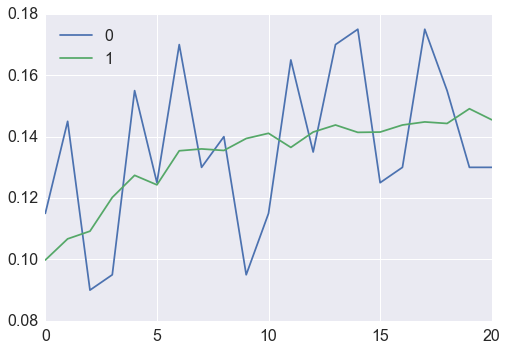

In [163]:
pd.DataFrame(list(zip(t.record_train_scores, t.record_test_scores))).plot()

In [ ]:
####
#
#Visualizations and Analysis
#
####

In [7]:
validation_predictions = t.predict(X_val)
validation_probs = t.predict_proba(X_val)
validation_ground_truth = Y_val

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def get_precision(confusion_matrix, iclass):
    '''
    Given a confusion matrix, calculate the precision for a given class

    confusion_matrix: An N-by-N matrix where N is the number of classes
    iclass: The name of the class assigned "positive" in a one-vs-all comparison
    '''
    TP = confusion_matrix.loc[iclass,iclass]
    FP = confusion_matrix[iclass].sum() - TP
    return TP / (TP + FP)

def get_recall(confusion_matrix, iclass):
    '''
    Given a confusion matrix, calculate the recall for a given class

    confusion_matrix: An N-by-N matrix where N is the number of classes
    iclass: The name of the class assigned "positive" in a one-vs-all comparison
    '''
    TP = confusion_matrix.loc[iclass,iclass]
    FN = confusion_matrix.loc[iclass].sum() - TP
    return TP / (TP + FN)

def get_f1_score(confusion_matrix, iclass):
    '''
    Given a confusion matrix, calculate the f1-score for a given class
    Formula taken from: https://www.toyota-ti.ac.jp/Lab/Denshi/COIN/people/yutaka.sasaki/F-measure-YS-26Oct07.pdf

    confusion_matrix: An N-by-N matrix where N is the number of classes
    iclass: The name of the class assigned "positive" in a one-vs-all comparison
    '''
    TP = confusion_matrix.loc[iclass,iclass]
    FP = confusion_matrix[iclass].sum() - TP
    FN = confusion_matrix.loc[iclass].sum() - TP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    return 2 * (precision * recall) / (precision + recall)
    #return 2*TP / (2*TP+FP+FN)
    
def get_multiclass_confusion_matrix(prediction,label):
    '''
    Takes the predicted classes and ground truth of a classification exercise, returning the confusion matrix.
    Results and label should have identical class names, lengths and unique class counts.

    results: a 1-dimensional vector containing the classes
    label: a 1-dimensional vector containing the ground truth
    '''
    conf_matrix = pd.DataFrame(list(zip(prediction,label)), columns=['predicted','ground_truth'])
    conf_matrix['const'] = 1
    conf_matrix = pd.pivot_table(data=conf_matrix, 
                               index='ground_truth', 
                               columns='predicted', 
                               values='const', 
                               aggfunc=sum)
    conf_matrix = conf_matrix.fillna(0)
    return conf_matrix

def heatmap_confusion_matrix(conf_matrix):
    '''
    Projects the confusion matrix as a heatmap, with the 
    '''
    plt.figure(figsize=(12,10))
    g = sns.heatmap(conf_matrix, cbar_kws={'label':'Frequency'})
    return g

def get_curve(buckets, probabilities, iclass, ground_truth):
    probs = probabilities[:,iclass]
    
    percentiles = [np.percentile(probs,q/10.0) for q in range(1000)]
    matched = pd.DataFrame(list(zip(probs, ground_truth)), 
                           columns=['prob_'+str(iclass),'class'])
    all_T = matched[matched['class']==iclass]['prob_'+str(iclass)]
    all_N = matched[matched['class']!=iclass]['prob_'+str(iclass)]
    
    buckets[str(iclass)+'_tpr'] = [(all_T > i).mean() for i in percentiles]
    buckets[str(iclass)+'_fpr'] = [(all_N > i).mean() for i in percentiles]
    return buckets

def get_curve_dataframe(probabilities, ground_truth):
    buckets = pd.DataFrame()
    for iclass in set(ground_truth):
        buckets = get_curve(buckets, probabilities, iclass, ground_truth)
    return buckets

def average_out_curves(curvy_bucket, ground_truth):
    curvy_bucket = curvy_bucket.copy()
    curvy_bucket['average_tpr'] = np.sum([
        curvy_bucket[str(iclass)+'_tpr'] * (ground_truth==iclass).mean() for iclass in set(ground_truth)
    ], axis=0)
    
    curvy_bucket['average_fpr'] = np.sum([
        curvy_bucket[str(iclass)+'_fpr'] * (ground_truth==iclass).mean() for iclass in set(ground_truth)
    ], axis=0)
    
    return curvy_bucket[['average_tpr','average_fpr']]

def get_auc(curvy_bucketframe):
    auc = -np.trapz(y=curvy_bucketframe['average_tpr'], x=curvy_bucketframe['average_fpr'])
    return auc

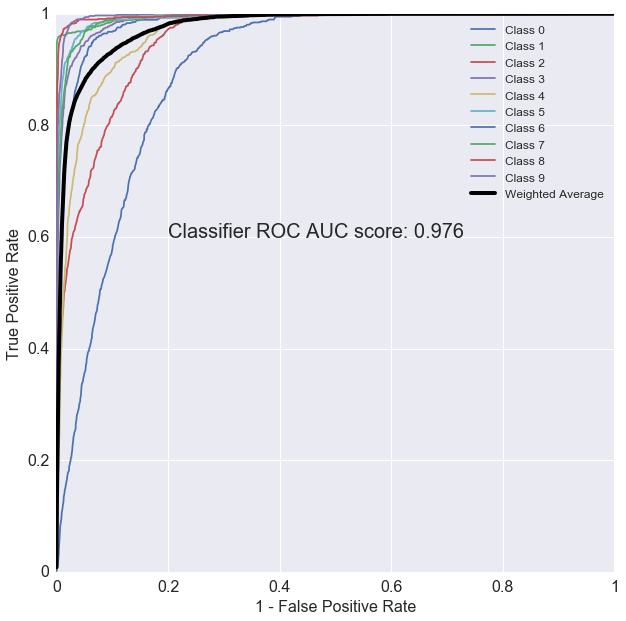

In [12]:
buckets = get_curve_dataframe(validation_probs, validation_ground_truth)
average_buckets = average_out_curves(buckets, validation_ground_truth)
ax = plt.subplot()
for iclass in range(10):
    g = buckets.plot(x=str(iclass)+"_fpr",y=str(iclass)+"_tpr", ax=ax)
    
g = average_buckets.sort_index(ascending=False
        ).plot(x='average_fpr', y='average_tpr', linewidth=4, ax=ax, color="black", figsize=(10,10))
g.set_xlabel("1 - False Positive Rate", fontsize=16)
g.set_ylabel("True Positive Rate", fontsize=16)
g.set_xticklabels([0,0.2,0.4,0.6,0.8,1], fontsize=16)
g.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize=16)
    
g.legend(['Class '+str(i) for i in range(10)] + ['Weighted Average'], fontsize=12)

plt.text(0.2,0.6,"Classifier ROC AUC score: {:.3f}".format(get_auc(average_buckets)), fontsize=20)

/Users/jmacdonald/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


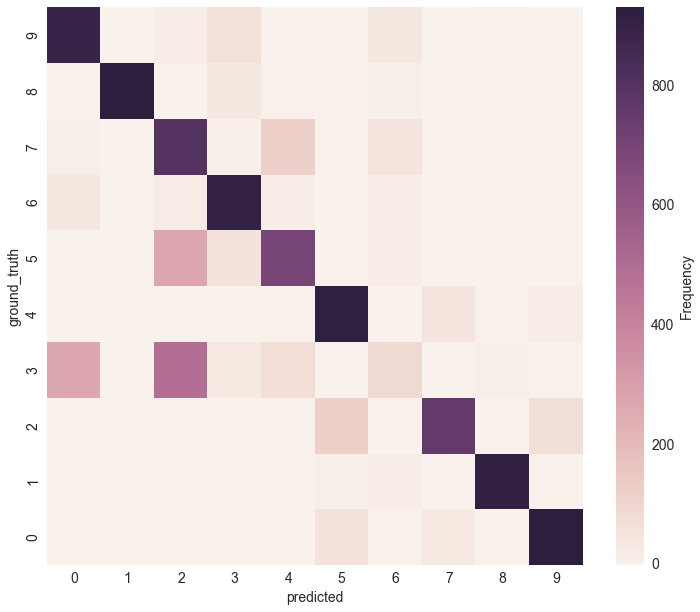

In [46]:
sns.set(font_scale=1.6)
cm = get_multiclass_confusion_matrix(validation_predictions, validation_ground_truth)
g = heatmap_confusion_matrix(cm)
g.figure.axes[-1].yaxis.label.set_size(14)
g.figure.axes[-1].yaxis.set_ticklabels([0,200,400,600,800], fontsize=14)

g.figure.axes[0].xaxis.set_ticklabels([0,1,2,3,4,5,6,7,8,9], fontsize=14)
g.figure.axes[0].xaxis.label.set_size(14)
g.figure.axes[0].yaxis.set_ticklabels([0,1,2,3,4,5,6,7,8,9], fontsize=14)
g.figure.axes[0].yaxis.label.set_size(14)

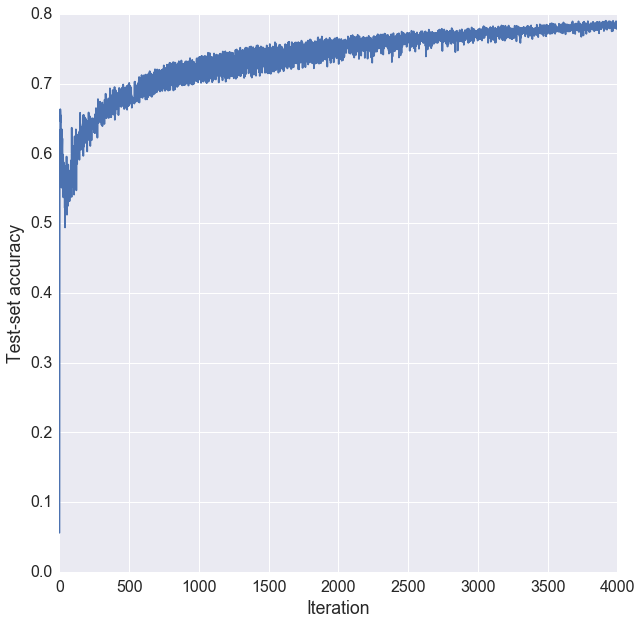

In [62]:
train_progress = pd.DataFrame([t.record_test_scores]).T
train_progress.columns=['Test Acc%']
g = train_progress.plot(figsize=(10,10), legend=False)
g.set_xlabel("Iteration")
g.set_ylabel("Test-set accuracy")

In [ ]:
moving = np.arange(10)
gamma = 1

(moving - 1) * (1 - gamma) * 